Goal is to explore regularization techniques

In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
%matplotlib inline

In [41]:
# get data
pickle_file = 'data/notMNIST_clean_python3.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (197901, 28, 28) (197901,)
Validation set (9876, 28, 28) (9876,)
Test set (9857, 28, 28) (9857,)


### Reshape Data such that each example is a row

In [42]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    # as.type is not needed as the array is already float32 but just in case
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print("Train Shapes --> Dataset: %s   Labels: %s" %(train_dataset.shape, train_labels.shape))
print("Valid Shapes --> Dataset: %s   Labels: %s" %(valid_dataset.shape, valid_labels.shape))
print("Test Shapes  --> Dataset: %s   Labels: %s" %(test_dataset.shape, test_labels.shape))

Train Shapes --> Dataset: (197901, 784)   Labels: (197901, 10)
Valid Shapes --> Dataset: (9876, 784)   Labels: (9876, 10)
Test Shapes  --> Dataset: (9857, 784)   Labels: (9857, 10)


In [63]:
def accuracy(predictions, labels):
    return 100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0]

## L2 Regularization

### Logistic Regression Model + SGD

In [6]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    
    """Input data. For the training data, we use a placeholder that will be fed
    at run time with a training minibatch"""
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    beta = tf.placeholder(tf.float32)
    
    """    Variables - Weights
    
    These are the parameters that we are going to be training.
    Weights are initiallized randomly and the biases to zero
    """
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    """Training Computation
  
    We multiply the inputs with the weight matrix, and add biases. 
    We compute then calculate the softmax and cross-entropy (it's one 
    operation in TensorFlow, because it's very common, and it can be optimized). 
    We take the average of this cross-entropy across all training examples: that's our loss.
    """
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
           beta * tf.nn.l2_loss(weights)
    
    """Optimizer
    We now find the minimum of this loss using gradient descent
    """
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    """Predictions for the training, validation and test data.
    
    These are not part of training, but merely here so that we can report
    accuracy figures as we train
    """
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [7]:
%%time
num_steps = 3001
regularization_parameters = np.array([0, .00001, .00003, .0001, .0003, .001, .003, .01]).astype(np.float32)
acc = []

for reg_param in regularization_parameters:
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):

            """This offset is an integer of the batch size, Such that 
            we are taking the batches not in the order they are presented."""
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size)]
            batch_labels = train_labels[offset:(offset + batch_size)]

            """Prepare a dictionary telling the session where to feed the minibatch.
            The key of the dictionary is the placeholder node of the graph to be fed,
            and the value is the numpy array to feed to it."""
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : reg_param}

            # Perform calculations
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)

#             # Give feedback every 500 steps
#             if step % 500 == 0:
#                 print("Minibatch loss at step %d: %f" % (step, l))
#                 print("Minibatch accuracy: \t%.1f%%" % accuracy(predictions, batch_labels))
#                 print("Validation accuracy: \t%.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
        acc.append(accuracy(test_prediction.eval(), test_labels))
        print("Regularization Parameter: %.3f\tTest accuracy: %.1f%%" %(reg_param, acc[-1]))

Regularization Parameter: 0.000	Test accuracy: 85.6%
Regularization Parameter: 0.000	Test accuracy: 85.6%
Regularization Parameter: 0.000	Test accuracy: 85.9%
Regularization Parameter: 0.000	Test accuracy: 86.3%
Regularization Parameter: 0.000	Test accuracy: 87.3%
Regularization Parameter: 0.001	Test accuracy: 88.7%
Regularization Parameter: 0.003	Test accuracy: 88.6%
Regularization Parameter: 0.010	Test accuracy: 87.9%
CPU times: user 1min 2s, sys: 20.4 s, total: 1min 22s
Wall time: 40.7 s


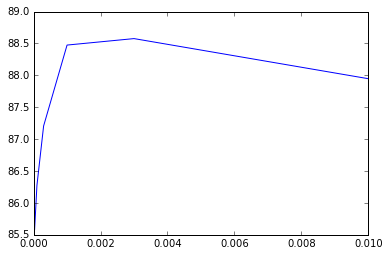

In [65]:
plt.plot(regularization_parameters, acc)

### Neural Network Model + SGD

In [38]:
batch_size = 128
hidden_layer_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    """Input data. For the training data, we use a placeholder that will be fed
    at run time with a training minibatch"""
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    beta = tf.placeholder(tf.float32)
    
    """    Variables - Weights
    
    These are the parameters that we are going to be training.
    Weights are initiallized randomly and the biases to zero
    """
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_nodes]))
    biases1 = tf.Variable(tf.zeros([hidden_layer_nodes]))
    
    weights2 = tf.Variable(tf.truncated_normal([hidden_layer_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    """Training Computation
  
    We multiply the inputs with the weight matrix, and add biases. 
    We compute then calculate the softmax and cross-entropy (it's one 
    operation in TensorFlow, because it's very common, and it can be optimized). 
    We take the average of this cross-entropy across all training examples: that's our loss.
    """
    hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(hidden, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))+ \
           beta * tf.nn.l2_loss(weights1) + beta * tf.nn.l2_loss(weights2)
    
    """Optimizer
    We now find the minimum of this loss using gradient descent
    """
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    """Predictions for the training, validation and test data.
    
    These are not part of training, but merely here so that we can report
    accuracy figures as we train
    """
    train_prediction = tf.nn.softmax(logits)
    
    hidden_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(hidden_valid, weights2) + biases2)
    
    hidden_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(hidden_test, weights2) + biases2)

In [67]:
%%time
num_steps = 3001
regularization_parameters = np.array([0, .00001, .00003, .0001, .0003, .001, .003, .01]).astype(np.float32)
acc = []

for reg_param in regularization_parameters:
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):

            """This offset is an integer of the batch size, Such that 
            we are taking the batches not in the order they are presented."""
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size)]
            batch_labels = train_labels[offset:(offset + batch_size)]

            """Prepare a dictionary telling the session where to feed the minibatch.
            The key of the dictionary is the placeholder node of the graph to be fed,
            and the value is the numpy array to feed to it."""
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : reg_param}

            # Perform calculations
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)

#             # Give feedback every 500 steps
#             if step % 500 == 0:
#                 print("Minibatch loss at step %d: %f" % (step, l))
#                 print("Minibatch accuracy: \t%.1f%%" % accuracy(predictions, batch_labels))
#                 print("Validation accuracy: \t%.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
        acc.append(accuracy(test_prediction.eval(), test_labels))
        print("Regularization Parameter: %.3f\tTest accuracy: %.1f%%" %(reg_param, acc[-1]))

Regularization Parameter: 0.000	Test accuracy: 88.9%
Regularization Parameter: 0.000	Test accuracy: 88.7%
Regularization Parameter: 0.000	Test accuracy: 88.4%
Regularization Parameter: 0.000	Test accuracy: 88.5%
Regularization Parameter: 0.000	Test accuracy: 89.2%
Regularization Parameter: 0.001	Test accuracy: 92.9%
Regularization Parameter: 0.003	Test accuracy: 92.5%
Regularization Parameter: 0.010	Test accuracy: 89.9%
CPU times: user 29min 45s, sys: 2min 19s, total: 32min 5s
Wall time: 11min 28s


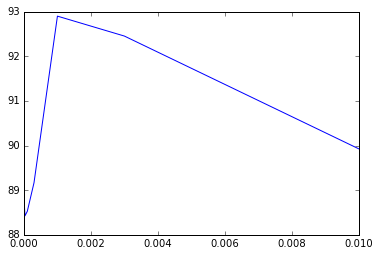

In [68]:
plt.plot(regularization_parameters, acc)

## Extreme Overfitting Case: Neural Network
Restrict training data to just a few. No SGD.

In [87]:
train_subset_size = 100
hidden_layer_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    """Input data. For the training data, we use a placeholder that will be fed
    at run time with a training minibatch"""
    tf_train_dataset = tf.constant(train_dataset[:train_subset_size])
    tf_train_labels = tf.constant(train_labels[:train_subset_size])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    """    Variables - Weights
    
    These are the parameters that we are going to be training.
    Weights are initiallized randomly and the biases to zero
    """
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_nodes]))
    biases1 = tf.Variable(tf.zeros([hidden_layer_nodes]))
    
    weights2 = tf.Variable(tf.truncated_normal([hidden_layer_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    """Training Computation
  
    We multiply the inputs with the weight matrix, and add biases. 
    We compute then calculate the softmax and cross-entropy (it's one 
    operation in TensorFlow, because it's very common, and it can be optimized). 
    We take the average of this cross-entropy across all training examples: that's our loss.
    """
    hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(hidden, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    """Optimizer
    We now find the minimum of this loss using gradient descent
    """
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    """Predictions for the training, validation and test data.
    
    These are not part of training, but merely here so that we can report
    accuracy figures as we train
    """
    train_prediction = tf.nn.softmax(logits)
    
    hidden_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(hidden_valid, weights2) + biases2)
    
    hidden_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(hidden_test, weights2) + biases2)

In [88]:
%%time
#Running the computation
num_steps = 301

def accuracy(predictions, labels):
    return 100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0]

with tf.Session(graph=graph) as session:
    """  This is a one-time operation which ensures the parameters get initialized as
    we described in the graph: random weights for the matrix, zeros for the
    biases."""
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        """Run the computations. We tell .run() that we want to run the optimizer,
        and get the loss value and the training predictions returned as numpy
        arrays."""
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if step % 100 == 0:
            print("Loss at step %d: %f" %(step, l))
            print("Training Accuracy: \t%.1f%%" % accuracy(predictions, train_labels[:train_subset_size]))
            """Calling .eval() on valid_prediction is basically like calling run(), but
            just to get that one numpy array. Note that it recomputes all its graph
            dependencies."""
            print("Validation Accuracy: \t%.1f%%" %accuracy(valid_prediction.eval(), valid_labels))
    print("\nTest Accuracy: \t\t%.1f%%" %accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 355.050690
Training Accuracy: 	5.0%
Validation Accuracy: 	20.0%
Loss at step 100: 0.000000
Training Accuracy: 	100.0%
Validation Accuracy: 	53.1%
Loss at step 200: 0.000000
Training Accuracy: 	100.0%
Validation Accuracy: 	53.1%
Loss at step 300: 0.000000
Training Accuracy: 	100.0%
Validation Accuracy: 	53.1%

Test Accuracy: 		56.8%
CPU times: user 22.7 s, sys: 1.6 s, total: 24.3 s
Wall time: 8.41 s


### Dropout Technique on Hidden Layer
Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides nn.dropout() for that, but you have to make sure it's only inserted during training.

In [184]:
train_subset_size = 100
hidden_layer_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    """Input data. For the training data, we use a placeholder that will be fed
    at run time with a training minibatch"""
    tf_train_dataset = tf.constant(train_dataset[:train_subset_size])
    tf_train_labels = tf.constant(train_labels[:train_subset_size])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    """    Variables - Weights
    
    These are the parameters that we are going to be training.
    Weights are initiallized randomly and the biases to zero
    """
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_nodes]))
    biases1 = tf.Variable(tf.zeros([hidden_layer_nodes]))
    
    weights2 = tf.Variable(tf.truncated_normal([hidden_layer_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    keep_prob = tf.placeholder(tf.float32)
    
    """Training Computation
  
    We multiply the inputs with the weight matrix, and add biases. 
    We compute then calculate the softmax and cross-entropy (it's one 
    operation in TensorFlow, because it's very common, and it can be optimized). 
    We take the average of this cross-entropy across all training examples: that's our loss.
    """
    hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    hidden_drop = tf.nn.dropout(hidden, keep_prob=keep_prob)
    logits = tf.matmul(hidden_drop, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    """Optimizer
    We now find the minimum of this loss using gradient descent
    """
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    """Predictions for the training, validation and test data.
    
    These are not part of training, but merely here so that we can report
    accuracy figures as we train
    """
    train_prediction = tf.nn.softmax(logits)
    
    hidden_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(hidden_valid, weights2) + biases2)
    
    hidden_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(hidden_test, weights2) + biases2)

In [185]:
%%time
#Running the computation
num_steps = 301

def accuracy(predictions, labels):
    return 100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0]

with tf.Session(graph=graph) as session:
    """  This is a one-time operation which ensures the parameters get initialized as
    we described in the graph: random weights for the matrix, zeros for the
    biases."""
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        """Run the computations. We tell .run() that we want to run the optimizer,
        and get the loss value and the training predictions returned as numpy
        arrays."""
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict={keep_prob : 0.6})
        if step % 100 == 0:
            print("Loss at step %d: %f" %(step, l))
            print("Accuracy on training with dropout: \t%.1f%%" %accuracy(predictions, train_labels[:train_subset_size]))
            print("Training Accuracy: \t%.1f%%" %accuracy(train_prediction.eval({keep_prob : 1.0}), train_labels[:train_subset_size]))
            """Calling .eval() on valid_prediction is basically like calling run(), but
            just to get that one numpy array. Note that it recomputes all its graph
            dependencies."""
            print("Validation Accuracy: \t%.1f%%" %accuracy(valid_prediction.eval(), valid_labels))
    print("\nTest Accuracy: \t\t%.1f%%" %accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 407.833954
Accuracy on training with dropout: 	13.0%
Training Accuracy: 	30.0%
Validation Accuracy: 	16.6%
Loss at step 100: 0.000000
Accuracy on training with dropout: 	100.0%
Training Accuracy: 	100.0%
Validation Accuracy: 	60.5%
Loss at step 200: 0.000000
Accuracy on training with dropout: 	100.0%
Training Accuracy: 	100.0%
Validation Accuracy: 	60.9%
Loss at step 300: 0.000000
Accuracy on training with dropout: 	100.0%
Training Accuracy: 	100.0%
Validation Accuracy: 	60.9%

Test Accuracy: 		65.4%
CPU times: user 23.6 s, sys: 1.65 s, total: 25.2 s
Wall time: 8.63 s


## Deep Neural Network + SGD - 1 Layer - Dropout
Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is 97.1%.

Another one is to use learning rate decay:
`python
global_step = tf.Variable(0)  # count the number of steps taken.
learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)`

In [176]:
batch_size = 128
hidden_layer_1_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    """Input data. For the training data, we use a placeholder that will be fed
    at run time with a training minibatch"""
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    """    Variables - Weights
    
    These are the parameters that we are going to be training.
    Weights are initiallized randomly and the biases to zero
    """
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_1_nodes]))
    biases1 = tf.Variable(tf.zeros([hidden_layer_1_nodes]))
    
    weights2 = tf.Variable(tf.truncated_normal([hidden_layer_1_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    """Training Computation
  
    We multiply the inputs with the weight matrix, and add biases. 
    We compute then calculate the softmax and cross-entropy (it's one 
    operation in TensorFlow, because it's very common, and it can be optimized). 
    We take the average of this cross-entropy across all training examples: that's our loss.
    """
    hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    hidden1 = tf.nn.dropout(hidden1, 0.6)
    logits = tf.matmul(hidden1, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) 
#            tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2)
    
    """Optimizer
    We now find the minimum of this loss using gradient descent
    """
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 100000, 0.95, staircase = True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
#     optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    """Predictions for the training, validation and test data.
    
    These are not part of training, but merely here so that we can report
    accuracy figures as we train
    """
    train_prediction = tf.nn.softmax(logits)
    
    hidden1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(hidden1, weights2) + biases2)
    
    hidden1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(hidden1, weights2) + biases2)

In [177]:
%%time
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        
        """This offset is an integer of the batch size, Such that 
        we are taking the batches not in the order they are presented."""
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size)]
        batch_labels = train_labels[offset:(offset + batch_size)]
        
        """Prepare a dictionary telling the session where to feed the minibatch.
        The key of the dictionary is the placeholder node of the graph to be fed,
        and the value is the numpy array to feed to it."""
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        # Perform calculations
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        
        # Give feedback every 500 steps
        if step % 500 == 0:
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: \t%.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: \t%.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("\nTest accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 447.419128
Minibatch accuracy: 	6.2%
Validation accuracy: 	21.8%
Minibatch loss at step 500: 40.777122
Minibatch accuracy: 	70.3%
Validation accuracy: 	79.4%
Minibatch loss at step 1000: 23.834034
Minibatch accuracy: 	75.8%
Validation accuracy: 	77.9%
Minibatch loss at step 1500: 12.013689
Minibatch accuracy: 	70.3%
Validation accuracy: 	79.6%
Minibatch loss at step 2000: 9.719074
Minibatch accuracy: 	69.5%
Validation accuracy: 	80.5%
Minibatch loss at step 2500: 2.278395
Minibatch accuracy: 	77.3%
Validation accuracy: 	80.0%
Minibatch loss at step 3000: 2.928926
Minibatch accuracy: 	78.1%
Validation accuracy: 	79.9%
Minibatch loss at step 3500: 4.783579
Minibatch accuracy: 	78.1%
Validation accuracy: 	79.8%

Test accuracy: 86.4%
CPU times: user 4min 16s, sys: 15.9 s, total: 4min 32s
Wall time: 1min 33s


## Deep Neural Network + SGD - 2 Layer - Dropout
Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is 97.1%.

Another one is to use learning rate decay:
`python
global_step = tf.Variable(0)  # count the number of steps taken.
learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)`

In [254]:
batch_size = 256
hidden_layer_1_nodes = 1024
hidden_layer_2_nodes = 512

graph = tf.Graph()
with graph.as_default():
    """Input data. For the training data, we use a placeholder that will be fed
    at run time with a training minibatch"""
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    """    Variables - Weights
    
    These are the parameters that we are going to be training.
    Weights are initiallized randomly and the biases to zero
    """
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_1_nodes]))
    biases1 = tf.Variable(tf.zeros([hidden_layer_1_nodes]))
    
    weights2 = tf.Variable(tf.truncated_normal([hidden_layer_1_nodes, hidden_layer_2_nodes]))
    biases2 = tf.Variable(tf.zeros([hidden_layer_2_nodes]))
    
    weights3 = tf.Variable(tf.truncated_normal([hidden_layer_2_nodes, num_labels]))
    biases3 = tf.Variable(tf.zeros([num_labels]))
    
    """Training Computation
  
    We multiply the inputs with the weight matrix, and add biases. 
    We compute then calculate the softmax and cross-entropy (it's one 
    operation in TensorFlow, because it's very common, and it can be optimized). 
    We take the average of this cross-entropy across all training examples: that's our loss.
    """
    hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
#     hidden1 = tf.nn.dropout(hidden1, 0.6)
    hidden2 = tf.nn.relu(tf.matmul(hidden1, weights2) + biases2)
#     hidden2 = tf.nn.dropout(hidden2, 0.6)
    logits = tf.matmul(hidden2, weights3) + biases3
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    """Optimizer
    We now find the minimum of this loss using gradient descent
    """
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.001, global_step, 100000, 0.95, staircase = True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
#     optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    """Predictions for the training, validation and test data.
    
    These are not part of training, but merely here so that we can report
    accuracy figures as we train
    """
    train_prediction = tf.nn.softmax(logits)
    
    hidden1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    hidden2 = tf.nn.relu(tf.matmul(hidden1, weights2) + biases2)
    valid_prediction = tf.nn.softmax(tf.matmul(hidden2, weights3) + biases3)
    
    hidden1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    hidden2 = tf.nn.relu(tf.matmul(hidden1, weights2) + biases2)
    test_prediction = tf.nn.softmax(tf.matmul(hidden2, weights3) + biases3)

In [ ]:
%%time
num_steps = 30001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        
        """This offset is an integer of the batch size, Such that 
        we are taking the batches not in the order they are presented."""
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size)]
        batch_labels = train_labels[offset:(offset + batch_size)]
        
        """Prepare a dictionary telling the session where to feed the minibatch.
        The key of the dictionary is the placeholder node of the graph to be fed,
        and the value is the numpy array to feed to it."""
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        # Perform calculations
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        
        # Give feedback every 500 steps
        if step % 2000 == 0:
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: \t%.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: \t%.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("\nTest accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3781.179443
Minibatch accuracy: 	12.9%
Validation accuracy: 	21.7%


## Deep Neural Network + SGD - 3 Layer - Dropout
Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is 97.1%.

Another one is to use learning rate decay:
`python
global_step = tf.Variable(0)  # count the number of steps taken.
learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)`

In [252]:
batch_size = 256
hidden_layer_1_nodes = 1024
hidden_layer_2_nodes = 512
hidden_layer_3_nodes = 256

graph = tf.Graph()
with graph.as_default():
    """Input data. For the training data, we use a placeholder that will be fed
    at run time with a training minibatch"""
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    """    Variables - Weights
    
    These are the parameters that we are going to be training.
    Weights are initiallized randomly and the biases to zero
    """
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_1_nodes]))
    biases1 = tf.Variable(tf.zeros([hidden_layer_1_nodes]))
    
    weights2 = tf.Variable(tf.truncated_normal([hidden_layer_1_nodes, hidden_layer_2_nodes]))
    biases2 = tf.Variable(tf.zeros([hidden_layer_2_nodes]))
    
    weights3 = tf.Variable(tf.truncated_normal([hidden_layer_2_nodes, hidden_layer_3_nodes]))
    biases3 = tf.Variable(tf.zeros([hidden_layer_3_nodes]))
    
    weights4 = tf.Variable(tf.truncated_normal([hidden_layer_3_nodes, num_labels]))
    biases4 = tf.Variable(tf.zeros([num_labels]))
    
    """Training Computation
  
    We multiply the inputs with the weight matrix, and add biases. 
    We compute then calculate the softmax and cross-entropy (it's one 
    operation in TensorFlow, because it's very common, and it can be optimized). 
    We take the average of this cross-entropy across all training examples: that's our loss.
    """
    hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    hidden1 = tf.nn.dropout(hidden1, 0.6)
    hidden2 = tf.nn.relu(tf.matmul(hidden1, weights2) + biases2)
    hidden2 = tf.nn.dropout(hidden2, 0.6)
    hidden3 = tf.nn.relu(tf.matmul(hidden2, weights3) + biases3)
    hidden3 = tf.nn.dropout(hidden3, 0.6)
    logits = tf.matmul(hidden3, weights4) + biases4
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
#            .001 * tf.nn.l2_loss(weights1) + .001 * tf.nn.l2_loss(weights2) + .001 * tf.nn.l2_loss(weights3) 
    
    
    """Optimizer
    We now find the minimum of this loss using gradient descent
    """
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.00001, global_step, 100000, 0.95, staircase = True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
#     optimizer = tf.train.GradientDescentOptimizer(0.0001).minimize(loss)
    
    """Predictions for the training, validation and test data.
    
    These are not part of training, but merely here so that we can report
    accuracy figures as we train
    """
    train_prediction = tf.nn.softmax(logits)
    
    hidden1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    hidden2 = tf.nn.relu(tf.matmul(hidden1, weights2) + biases2)
    hidden3 = tf.nn.relu(tf.matmul(hidden2, weights3) + biases3)
    valid_prediction = tf.nn.softmax(tf.matmul(hidden3, weights4) + biases4)
    
    hidden1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    hidden2 = tf.nn.relu(tf.matmul(hidden1, weights2) + biases2)
    hidden3 = tf.nn.relu(tf.matmul(hidden2, weights3) + biases3)
    test_prediction = tf.nn.softmax(tf.matmul(hidden3, weights4) + biases4)

In [253]:
%%time
num_steps = 30001
batch_size = 256

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        
        """This offset is an integer of the batch size, Such that 
        we are taking the batches not in the order they are presented."""
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size)]
        batch_labels = train_labels[offset:(offset + batch_size)]
        
        """Prepare a dictionary telling the session where to feed the minibatch.
        The key of the dictionary is the placeholder node of the graph to be fed,
#         and the value is the numpy array to feed to it."""
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        # Perform calculations
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        
        # Give feedback every 500 steps
        if step % 1000 == 0:
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: \t%.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: \t%.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("\nTest accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 103468.234375
Minibatch accuracy: 	14.1%
Validation accuracy: 	9.4%
Minibatch loss at step 1000: 16517.367188
Minibatch accuracy: 	41.0%
Validation accuracy: 	69.3%
Minibatch loss at step 2000: 10110.689453
Minibatch accuracy: 	42.2%
Validation accuracy: 	71.6%
Minibatch loss at step 3000: 6874.708496
Minibatch accuracy: 	44.5%
Validation accuracy: 	71.3%
Minibatch loss at step 4000: 4535.848633
Minibatch accuracy: 	48.0%
Validation accuracy: 	71.5%


KeyboardInterrupt: 